In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# make a 2d heatmap
from matplotlib.colors import LogNorm
from sklearn.metrics import roc_curve, auc

## 1. Model trained on a larger dataset (model_matched) compared to a smaller dataset (model)

In [2]:
df = pd.read_csv('/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/tm-vec/malidup_sequences_and_tm_scores_preds.csv')

In [4]:
from Bio.Align import PairwiseAligner

def identity(alignment):
    s = np.array(alignment)
    matches = (s[0] == s).all(axis=0)
    seq_id = 100 * matches.sum() / len(alignment[0])
    return seq_id

def sequence_identity(seq1, seq2):
    """
    Aligns two sequences and returns the sequence identity in percent.
    """
    aligner = PairwiseAligner()
    aligner.mode = 'local'
    alignments = aligner.align(seq1, seq2)
    seq_id = identity(alignments[0])
    return seq_id

In [5]:
df["seq_id"] = df.apply(lambda row: sequence_identity(row["Sequence 1"], row["Sequence 2"]), axis=1)
# group into bucets of 5
df["seq_id_bucket"] = df["seq_id"].apply(lambda x: int(x/5)*5)

/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/conda-envs/data-analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/conda-envs/data-analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/conda-envs/data-analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option

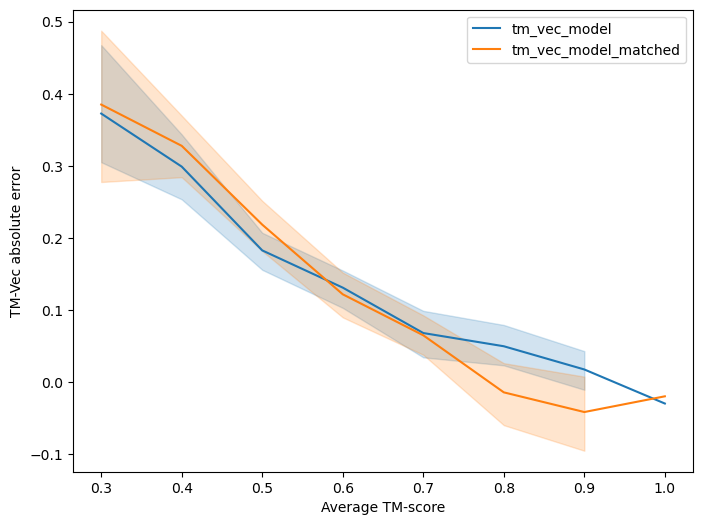

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
df["tm_avg"] = (df["Tm_score1"] + df["TM_score2"]) / 2
df["tm_avg_rounded"] = df["tm_avg"].round(1)

for col in ["tm_vec_model", "tm_vec_model_matched"]:
    df[f"prediction_error_{col}"] = (df[col] - df[f"tm_avg"]).round(2)
    sns.lineplot(x="tm_avg_rounded", y=f"prediction_error_{col}", data=df, ax=ax, errorbar=("ci", 95), label=col)

ax.set_xlabel("Average TM-score")
ax.set_ylabel("TM-Vec absolute error")
ax.legend()

/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/conda-envs/data-analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/conda-envs/data-analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/conda-envs/data-analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option

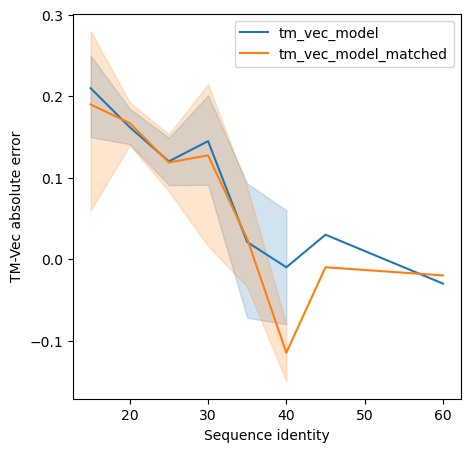

In [24]:
# do a lineplot with seq id
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for col in ["tm_vec_model", "tm_vec_model_matched"]:
    sns.lineplot(x="seq_id_bucket", y=f"prediction_error_{col}", data=df, ax=ax, errorbar=("ci", 95), label=col)

ax.set_xlabel("Sequence identity")
ax.set_ylabel("TM-Vec absolute error")
ax.legend();

/tmp/ipykernel_4024012/3217326334.py:17: RuntimeWarning: invalid value encountered in divide
  m3 = ax.pcolormesh(ybins, xbins, sums / counts, cmap='RdBu_r')


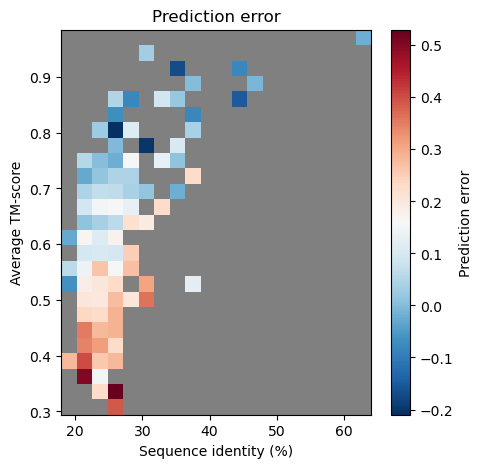

In [28]:
# make a 2d heatmap
# use seq_id and TM_avg as axes
# plot prediction_error_0 as values

df["prediction_error"] = df["prediction_error_tm_vec_model_matched"]

x = df["tm_avg"].values
y = df["seq_id"].values
z = df["prediction_error"].values


counts, xbins, ybins = np.histogram2d(x, y, bins=(25, 20))
sums, _, _ = np.histogram2d(x, y, weights=z, bins=(xbins, ybins))
fig, ax = plt.subplots(1, 1, figsize=(5, 5))


m3 = ax.pcolormesh(ybins, xbins, sums / counts, cmap='RdBu_r')
# fill empty colormesh squares
m3.cmap.set_under('blue')


# Cosmetics
ax.set_xlabel("Sequence identity (%)")
ax.set_ylabel("Average TM-score")
ax.set_title("Prediction error")
plt.colorbar(m3, ax=ax)
# add title to colorbar
cb = ax.collections[0].colorbar
cb.set_label("Prediction error")

# set all background color to black
ax.set_facecolor('grey')

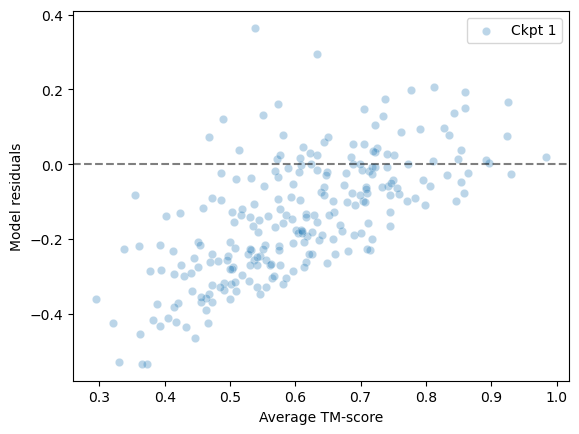

In [29]:
# plot avg TM-score and predicted_score_0
# on contour plot
df["residuals"] = df["tm_avg"] - df["tm_vec_model_matched"]
sns.scatterplot(x="tm_avg", y="residuals", data=df, label=f"Ckpt 1", alpha=0.3)
# add line on 0
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)

plt.xlabel("Average TM-score")
plt.ylabel("Model residuals");

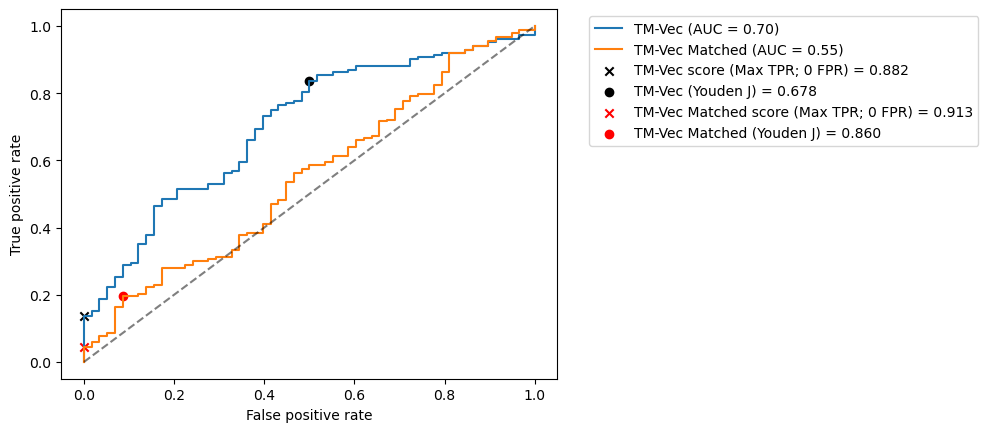

In [36]:
df["similar"] = df["tm_avg"] > 0.5

# TM-Vec Model
fpr_tm_vec, tpr_tm_vec, thresholds_tm_vec = roc_curve(df["similar"], df["tm_vec_model"])
roc_auc_tm_vec = auc(fpr_tm_vec, tpr_tm_vec)

# TM-Vec Model Matched
fpr_tm_vec_matched, tpr_tm_vec_matched, thresholds_tm_vec_matched = roc_curve(df["similar"], df["tm_vec_model_matched"])
roc_auc_tm_vec_matched = auc(fpr_tm_vec_matched, tpr_tm_vec_matched)

plt.plot(fpr_tm_vec, tpr_tm_vec, label=f"TM-Vec (AUC = {roc_auc_tm_vec:.2f})")
plt.plot(fpr_tm_vec_matched, tpr_tm_vec_matched, label=f"TM-Vec Matched (AUC = {roc_auc_tm_vec_matched:.2f})")

# add diagonal line
plt.plot([0, 1], [0, 1], color='k', linestyle='--', alpha=0.5)
# add axis
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

# TM-Vec Model
fpr_0_tm_vec = np.where(fpr_tm_vec > 0)[0][0] - 1
plt.scatter(fpr_tm_vec[fpr_0_tm_vec], tpr_tm_vec[fpr_0_tm_vec], color='k', marker='x', label=f"TM-Vec score (Max TPR; 0 FPR) = {thresholds_tm_vec[fpr_0_tm_vec]:.3f}")

youden_tm_vec = tpr_tm_vec - fpr_tm_vec
youden_max_tm_vec = np.argmax(youden_tm_vec)
plt.scatter(fpr_tm_vec[youden_max_tm_vec], tpr_tm_vec[youden_max_tm_vec], color='k', marker='o', label=f"TM-Vec (Youden J) = {thresholds_tm_vec[youden_max_tm_vec]:.3f}")

# TM-Vec Model Matched
fpr_0_tm_vec_matched = np.where(fpr_tm_vec_matched > 0)[0][0] - 1
plt.scatter(fpr_tm_vec_matched[fpr_0_tm_vec_matched], tpr_tm_vec_matched[fpr_0_tm_vec_matched], color='r', marker='x', label=f"TM-Vec Matched score (Max TPR; 0 FPR) = {thresholds_tm_vec_matched[fpr_0_tm_vec_matched]:.3f}")

youden_tm_vec_matched = tpr_tm_vec_matched - fpr_tm_vec_matched
youden_max_tm_vec_matched = np.argmax(youden_tm_vec_matched)
plt.scatter(fpr_tm_vec_matched[youden_max_tm_vec_matched], tpr_tm_vec_matched[youden_max_tm_vec_matched], color='r', marker='o', label=f"TM-Vec Matched (Youden J) = {thresholds_tm_vec_matched[youden_max_tm_vec_matched]:.3f}")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

### Summary
1. The model_matched was trained on a larger dataset compared to the model.
2. The model generalizes better on the test set compared to the model_matched.
3. The problem is likely in dataset bias. 

### Conclusions 
For now, it's better to use old model with high thresholds for the test set.

## 2. Additional benchmarks for the `model`

In [3]:
scores_df = pd.read_parquet("/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/tm-vec/tmvec_data/valid.parquet")
scores_preds = np.load("/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/tm-vec/valid_preds_0.npz")["arr_0"]
scores_preds1 = np.load("/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/tm-vec/valid_preds_1.npz")["arr_0"]
scores_preds = np.concatenate([scores_preds, scores_preds1], axis=0)

In [4]:
scores_df["seq1_len"] = scores_df["seq_query"].apply(len)
scores_df["seq2_len"] = scores_df["seq_target"].apply(len)

In [5]:
# calculate relative length of a seq2 to seq1
scores_df["seq2_len_rel"] = scores_df["seq2_len"] / scores_df["seq1_len"]
scores_df["seq1_len_rel"] = scores_df["seq1_len"] / scores_df["seq2_len"]

In [6]:
# scores_df.query("seq1_len_rel > 0.6 and seq2_len_rel < 1.6 and tm_avg > 0.6").seq_id.describe()

In [7]:
scores_df = scores_df.iloc[:scores_preds.shape[0]]
scores_df["tm_vec_pred"] = scores_preds

In [8]:
scores_df["prediction_error"] = scores_df["tm_vec_pred"] - scores_df["tm_avg"]

Text(0, 0.5, 'Average TM-score')

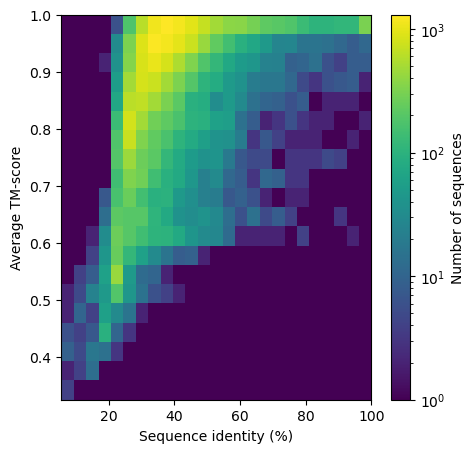

In [9]:
x = scores_df["seq_id"].values
y = scores_df["tm_avg"].values

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
_, xedges, yedges, h = ax.hist2d(x, y, bins=(25, 20), norm=LogNorm(clip=True))

# add colorbar
plt.colorbar(h, ax=ax)
# add title to colorbar
cb = ax.collections[0].colorbar
cb.set_label('Number of sequences')

# Cosmetics
ax.set_xlabel("Sequence identity (%)")
ax.set_ylabel("Average TM-score")


/tmp/ipykernel_4026914/2295804082.py:11: RuntimeWarning: invalid value encountered in divide
  m3 = ax.pcolormesh(ybins, xbins, sums / counts, cmap='RdBu_r', vmin=-0.4, vmax=0.4)


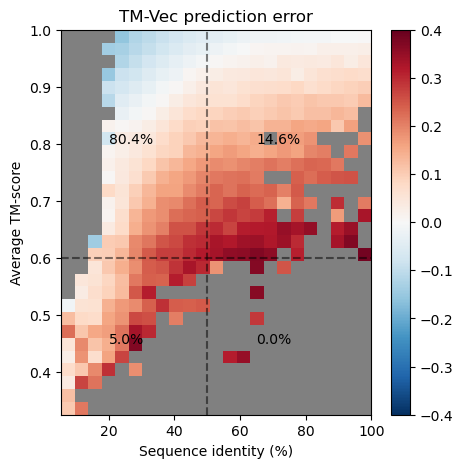

In [10]:
# plot a 2d hist
x = scores_df["tm_avg"].values
y = scores_df["seq_id"].values
z = scores_df["prediction_error"].values


counts, xbins, ybins = np.histogram2d(x, y, bins=(30, 23))
sums, _, _ = np.histogram2d(x, y, weights=z, bins=(xbins, ybins))
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

m3 = ax.pcolormesh(ybins, xbins, sums / counts, cmap='RdBu_r', vmin=-0.4, vmax=0.4)

# Cosmetics
ax.set_xlabel("Sequence identity (%)")
ax.set_ylabel("Average TM-score")
ax.set_title("TM-Vec prediction error")
plt.colorbar(m3, ax=ax)
# add lines on 30% seq_id and 0.6 TM-score
plt.axvline(x=50, color='k', linestyle='--', alpha=0.5)
plt.axhline(y=0.6, color='k', linestyle='--', alpha=0.5)
# set all background color to black
ax.set_facecolor('grey')
# write percentages of data over quadrants
# top left
n = ((scores_df["seq_id"] < 50) & (scores_df["tm_avg"] > 0.6)).sum()
plt.text(20, 0.8, f"{n/scores_df.shape[0]*100:.1f}%", color='k')
# top right
n = ((scores_df["seq_id"] >= 50) & (scores_df["tm_avg"] > 0.6)).sum()
plt.text(65, 0.8, f"{n/scores_df.shape[0]*100:.1f}%", color='k')
# bottom left
n = ((scores_df["seq_id"] < 50) & (scores_df["tm_avg"] <= 0.6)).sum()
plt.text(20, 0.45, f"{n/scores_df.shape[0]*100:.1f}%", color='k')
# bottom right
n = ((scores_df["seq_id"] >= 50) & (scores_df["tm_avg"] <= 0.6)).sum()
plt.text(65, 0.45, f"{n/scores_df.shape[0]*100:.1f}%", color='k');

In [11]:
# subsample equal results from quadrants
max_samples = ((scores_df["seq_id"] <= 50) & (scores_df["tm_avg"] <= 0.5)).sum()

# top left
top_left = scores_df[(scores_df["seq_id"] < 50) & (scores_df["tm_avg"] > 0.5)].sample(max_samples, random_state=42)
# top right
top_right = scores_df[(scores_df["seq_id"] >= 50) & (scores_df["tm_avg"] > 0.5)].sample(max_samples, random_state=42)
# bottom left
bottom_left = scores_df[(scores_df["seq_id"] < 50) & (scores_df["tm_avg"] <= 0.5)].sample(max_samples, random_state=42)

In [12]:
balanced_scores_df = pd.concat([top_left, bottom_left, top_right])

/tmp/ipykernel_4026914/814685035.py:13: RuntimeWarning: invalid value encountered in divide
  m3 = ax.pcolormesh(ybins, xbins, sums / counts, cmap='RdBu_r', vmin=-0.4, vmax=0.4)


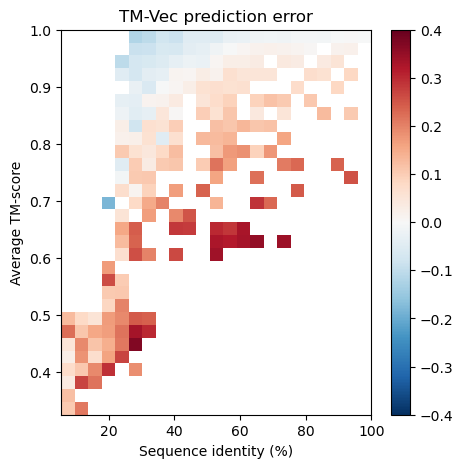

In [13]:
# make a heatmap for balanced scores

# plot a 2d hist
x = balanced_scores_df["tm_avg"].values
y = balanced_scores_df["seq_id"].values
z = balanced_scores_df["prediction_error"].values


counts, xbins, ybins = np.histogram2d(x, y, bins=(30, 23))
sums, _, _ = np.histogram2d(x, y, weights=z, bins=(xbins, ybins))
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

m3 = ax.pcolormesh(ybins, xbins, sums / counts, cmap='RdBu_r', vmin=-0.4, vmax=0.4)

# Cosmetics
ax.set_xlabel("Sequence identity (%)")
ax.set_ylabel("Average TM-score")
ax.set_title("TM-Vec prediction error")
plt.colorbar(m3, ax=ax)


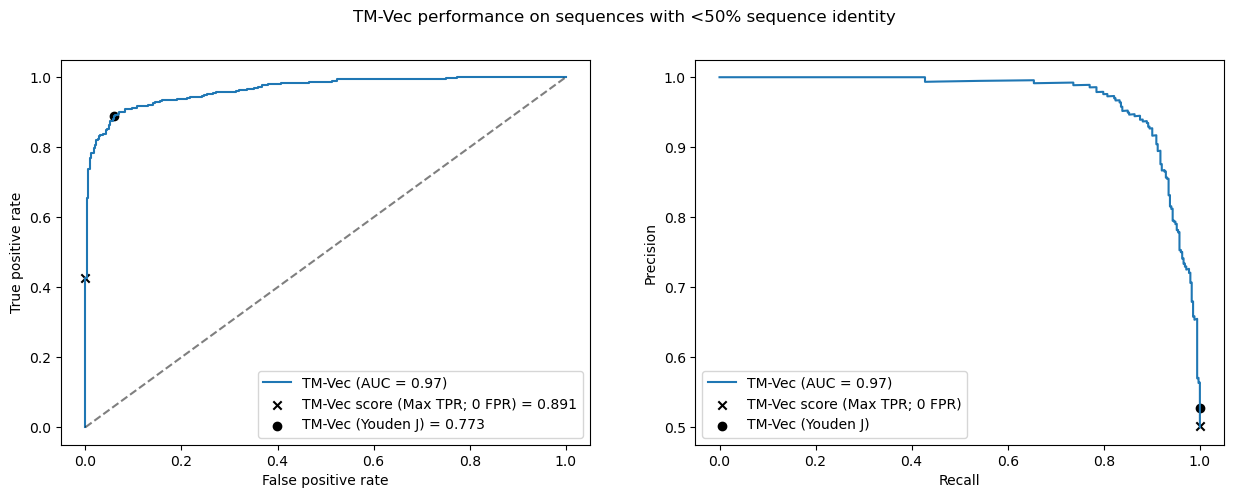

In [18]:
# under50_id = balanced_scores_df[(balanced_scores_df["seq_id"] < 50)]
under50_id = scores_df[(scores_df["seq_id"] < 50)]
# BALANCE TEST DATASET BY TM-SCORE
n_samples = under50_id["tm_avg"].apply(lambda x: x < 0.5).sum()
under50_id = pd.concat([under50_id[under50_id["tm_avg"] >= 0.5].sample(n_samples, random_state=42),
                        under50_id[under50_id["tm_avg"] < 0.5]])

# plot ROC curve for under 50% seq_id
fpr, tpr, thresholds = roc_curve(under50_id["tm_avg"] > 0.5, under50_id["tm_vec_pred"])
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(fpr, tpr, label=f"TM-Vec (AUC = {roc_auc:.2f})")
# add diagonal line
ax[0].plot([0, 1], [0, 1], color='k', linestyle='--', alpha=0.5)
# add axis
ax[0].set_xlabel("False positive rate")
ax[0].set_ylabel("True positive rate")

# lowest FPR point
fpr_0 = np.where(fpr > 0)[0][0] - 1
ax[0].scatter(fpr[fpr_0], tpr[fpr_0], color='k', marker='x', label=f"TM-Vec score (Max TPR; 0 FPR) = {thresholds[fpr_0]:.3f}")

# plot Youden J
youden = tpr - fpr
youden_max = np.argmax(youden)
ax[0].scatter(fpr[youden_max], tpr[youden_max], color='k', marker='o', label=f"TM-Vec (Youden J) = {thresholds[youden_max]:.3f}")
ax[0].legend()

# plot AUPRC curve
from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(under50_id["tm_avg"] > 0.5, under50_id["tm_vec_pred"])
roc_auc = auc(recall, precision)

ax[1].plot(recall, precision, label=f"TM-Vec (AUC = {roc_auc:.2f})")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")

# plot 0 FPR point
ax[1].scatter(recall[fpr_0], precision[fpr_0], color='k', marker='x', label=f"TM-Vec score (Max TPR; 0 FPR)")

# plot youden J
ax[1].scatter(recall[youden_max], precision[youden_max], color='k', marker='o', label=f"TM-Vec (Youden J)")


ax[1].legend()

fig.suptitle("TM-Vec performance on sequences with <50% sequence identity");

/tmp/ipykernel_4026366/1074200367.py:14: RuntimeWarning: invalid value encountered in divide
  m3 = ax1.pcolormesh(ybins, xbins, sums / counts, cmap='Reds')
/tmp/ipykernel_4026366/1074200367.py:28: RuntimeWarning: invalid value encountered in divide
  m3 = ax2.pcolormesh(ybins, xbins, sums / counts, cmap='Reds_r')


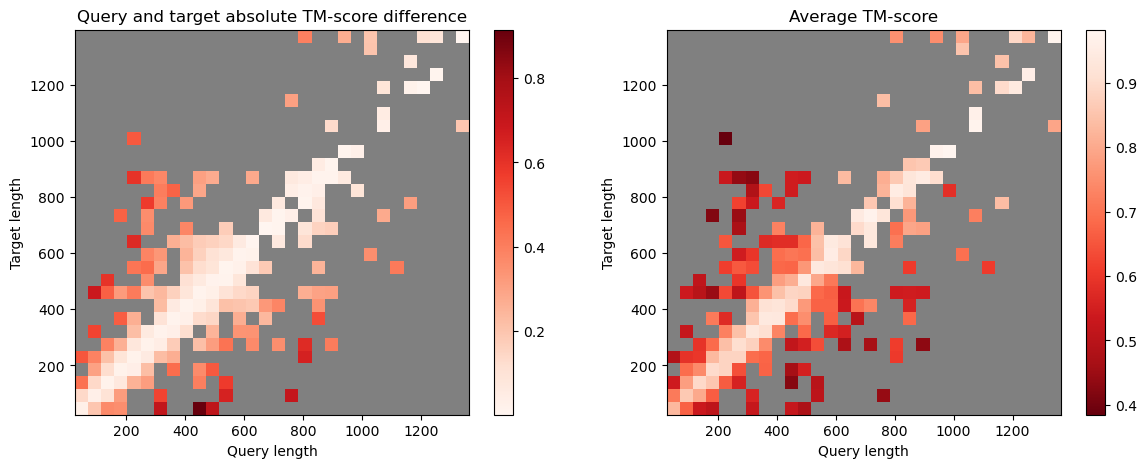

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# 2d hist seq_len1 and seq_len2
similar_prots = scores_df.sample(frac=0.1, random_state=42)
x = similar_prots["seq1_len"].values
y = similar_prots["seq2_len"].values
# TM-value diff
z1 = np.abs(similar_prots["tm_query"] - similar_prots["tm_target"])
z2 = similar_prots["tm_avg"]

counts, xbins, ybins = np.histogram2d(x, y, bins=(30, 30))
sums, _, _ = np.histogram2d(x, y, weights=z1, bins=(xbins, ybins))

m3 = ax1.pcolormesh(ybins, xbins, sums / counts, cmap='Reds')
# fill empty colormesh squares
m3.cmap.set_under('blue')

# Cosmetics
ax1.set_xlabel("Query length")
ax1.set_ylabel("Target length")
ax1.set_title("Query and target absolute TM-score difference")
plt.colorbar(m3, ax=ax1)
ax1.set_facecolor('grey')

counts, xbins, ybins = np.histogram2d(x, y, bins=(30, 30))
sums, _, _ = np.histogram2d(x, y, weights=z2, bins=(xbins, ybins))

m3 = ax2.pcolormesh(ybins, xbins, sums / counts, cmap='Reds_r')
# fill empty colormesh squares
m3.cmap.set_under('grey')

# Cosmetics
ax2.set_xlabel("Query length")
ax2.set_ylabel("Target length")
ax2.set_title("Average TM-score")
plt.colorbar(m3, ax=ax2)
ax2.set_facecolor('grey');

/tmp/ipykernel_4026366/2635173772.py:14: RuntimeWarning: invalid value encountered in divide
  m3 = ax.pcolormesh(ybins, xbins, sums / counts, cmap='Reds_r')


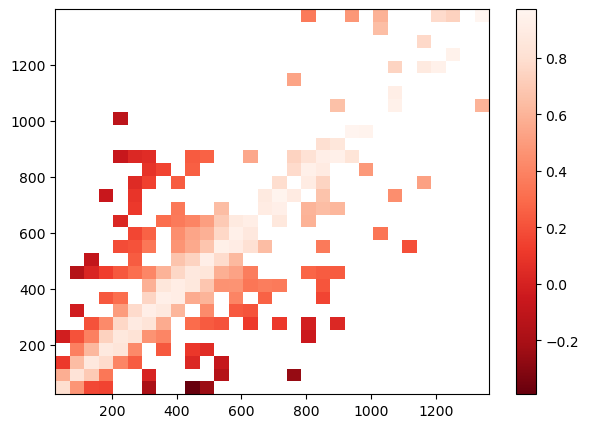

In [24]:
# plot heatmap
# subtract tm-error from tm-avg

# plot a 2d hist
x = similar_prots["seq1_len"].values
y = similar_prots["seq2_len"].values
z = z2 - z1


counts, xbins, ybins = np.histogram2d(x, y, bins=(30, 30))
sums, _, _ = np.histogram2d(x, y, weights=z, bins=(xbins, ybins))
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

m3 = ax.pcolormesh(ybins, xbins, sums / counts, cmap='Reds_r')
# fill background

# add colorbar
plt.colorbar(m3, ax=ax);